In [1]:
import numpy as np
from utils import JPtools as jpt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.cross_validation import train_test_split
%matplotlib inline
%config InlineBackend.figure_formats=['svg']

BATCH_SIZE = 555
#NETWORK_DIMS = {"T0":[20, 15, 7, 3], "T0'":[20, 20, 20, 15, 7, 3], "T":[20, 40, 20, 15, 7, 3]}
NETWORK_DIMS = [20, 40, 20, 15, 7, 3]
NETWORK_ACT = {"T + relu":'relu', "T + sigmoid":'sigmoid', "T + tanh":'tanh'}
#SIGMA_VALUES = [0.1, 0.2, 0.4]
SIGMA_VALUES = [0.2]
MAX_EPOCHS = 4800
NUMBER_OF_EPOCHS_PER_STEP = 200
record = {}

Using TensorFlow backend.
/Users/eliasrubin/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Couldn't import dot_parser, loading of dot files will not be possible.


/Users/eliasrubin/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


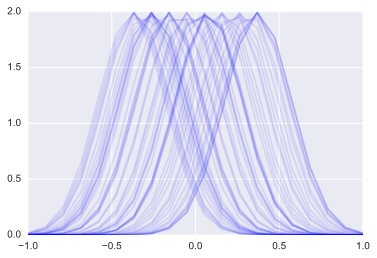

In [6]:
x,_ = jpt.manyPsf(samples = 20, batch_size=555)
plt.figure()
for i in xrange(len(x)/10):
    plt.plot(np.linspace(-1,1,20),x[i], c = 'b', alpha = 0.1)
plt.show()

In [2]:
%%capture
for sigma in SIGMA_VALUES:
    d = {} 
    X, xc = jpt.manyPsf(samples = 20, batch_size=555)
    X_train, X_val = train_test_split(X, test_size = 0.1, random_state = 42)
    xc_train, xc_val = train_test_split(xc, test_size = 0.1, random_state = 42)
    
    for label, act in NETWORK_ACT.items():
        jae = jpt.JPAutoEncoder(NETWORK_DIMS, act = act)
        current_epoch = 0
        num_epochs = []
        avg_chi2 = []
        d[label] = (num_epochs, avg_chi2)
        jae.pretrain(X_train, num_epoch = 200)
        jae.fine_train(X_train, num_epoch = 0)
        while current_epoch < MAX_EPOCHS:
            
            num_epochs.append(current_epoch)
            avg_chi2.append(jae.validation_chi2(X_val))
            
            jae.fine_train(X_train, num_epoch = NUMBER_OF_EPOCHS_PER_STEP)
            current_epoch += NUMBER_OF_EPOCHS_PER_STEP
        
    record[sigma] = d

In [27]:
%%capture
record2 = {}
MY_DIMS = {"T'":[20, 40, 30, 15, 7, 3]}
for sigma in SIGMA_VALUES:
    d = {}
    X, xc = jpt.manyPsf(samples = 20, batch_size=555, sigma = sigma)
    X_train, X_val = train_test_split(X, test_size = 0.1, random_state = 42)
    xc_train, xc_val = train_test_split(xc, test_size = 0.1, random_state = 42)
    for label, network in MY_DIMS.items():
        jae = jpt.JPAutoEncoder(network)
        current_epoch = 0
        num_epochs = []
        avg_chi2 = []
        d[label] = (num_epochs, avg_chi2)
        jae.pretrain(X_train, num_epoch = 200)
        jae.fine_train(X_train, num_epoch = 0)
        while current_epoch < MAX_EPOCHS:

            num_epochs.append(current_epoch)
            avg_chi2.append(jae.validation_chi2(X_val))

            jae.fine_train(X_train, num_epoch = NUMBER_OF_EPOCHS_PER_STEP)
            current_epoch += NUMBER_OF_EPOCHS_PER_STEP
            
    record2[sigma] = d

In [4]:
def plot_training_effectiveness(key, record_dict, savefig = False):
    d = record_dict[key]
    
    f = plt.figure()
    f.set_size_inches(8,6)
    with sns.cubehelix_palette(len(d), light = 0.6):
        for k, v in d.items():
            plt.semilogy(v[0], v[1], label = k)
        
    plt.ylabel(r'$\langle \chi^2 \rangle$', size = 14)
    plt.xlabel(r'Number of training epochs', size = 14)
    plt.legend(loc = 'upper right')
    plt.title("Training Effectiveness, width = {}".format(key/0.2))
    if savefig:
        plt.savefig("training-effectiveness-width-{}.pdf".format(key/0.2))
    plt.show()

/Users/eliasrubin/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


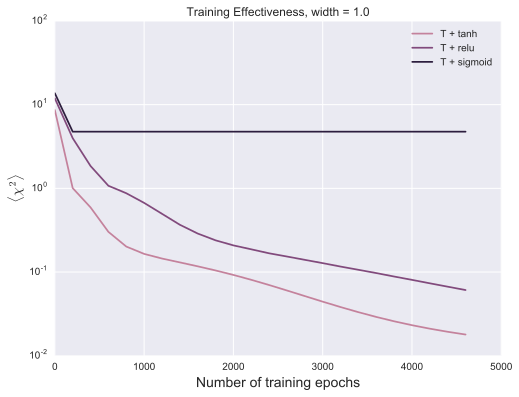

In [5]:
plot_training_effectiveness(0.2, record, savefig = False)

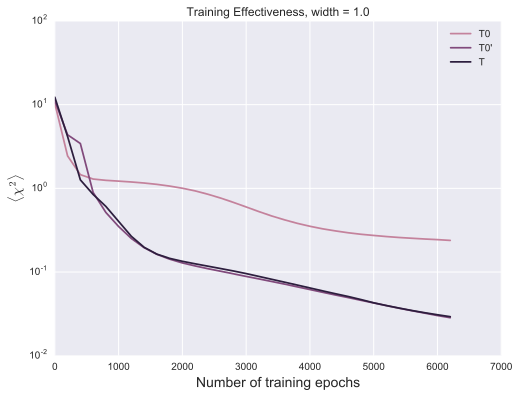

In [16]:
plot_training_effectiveness(0.2, record, savefig = True)

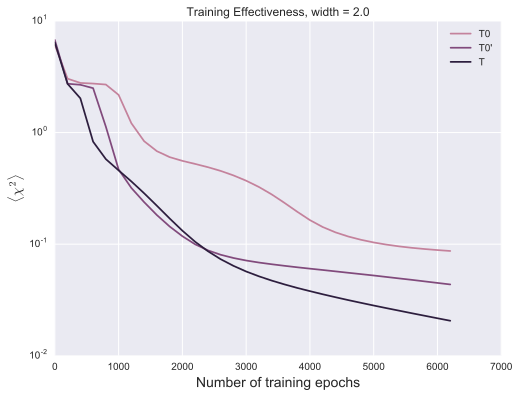

In [20]:
plot_training_effectiveness(0.4, record, savefig = True)

In [ ]:
plot_training_effectiveness(0.05, record, savefig = False)

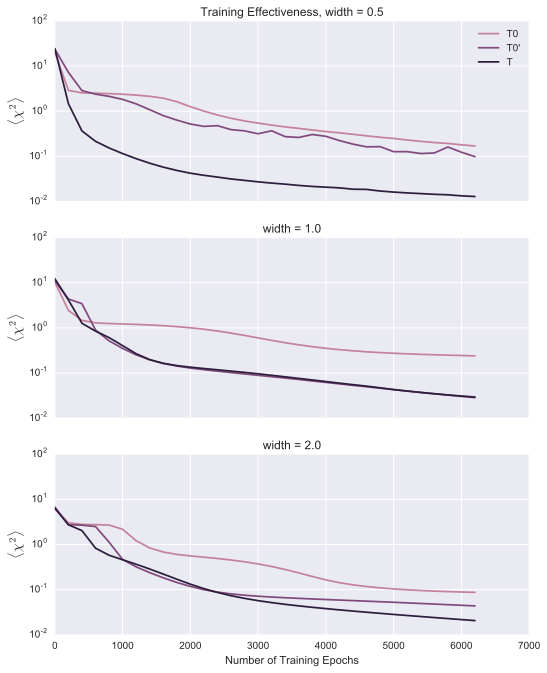

In [25]:
f, (ax1, ax2, ax3) = plt.subplots(3, sharex = True, sharey = True)
f.set_size_inches(8.5,11)
sns.set_palette(sns.cubehelix_palette(3, light = 0.6))
b = record[0.1]
c = record[0.2]
d = record[0.4]
ax1.semilogy(b['T0'][0], b['T0'][1], label = 'T0')
ax1.semilogy(b["T0'"][0], b["T0'"][1], label = "T0'")
ax1.semilogy(b["T"][0], b["T"][1], label = "T")
ax2.semilogy(c['T0'][0], c['T0'][1], label = 'T0')
ax2.semilogy(c["T0'"][0], c["T0'"][1], label = "T0'")
ax2.semilogy(c["T"][0], c["T"][1], label = "T")
ax3.semilogy(d['T0'][0], d['T0'][1], label = 'T0')
ax3.semilogy(d["T0'"][0], d["T0'"][1], label = "T0'")
ax3.semilogy(d["T"][0], d["T"][1], label = "T")
ax1.legend(loc = 'upper right')
ax1.set_title('Training Effectiveness, width = 0.5')
ax2.set_title('width = 1.0')
ax3.set_title('width = 2.0')
plt.xlabel("Number of Training Epochs")
ax1.set_ylabel(r'$\langle \chi^2 \rangle$', size = 14)
ax2.set_ylabel(r'$\langle \chi^2 \rangle$', size = 14)
ax3.set_ylabel(r'$\langle \chi^2 \rangle$', size = 14)
plt.savefig('Training Effectiveness composite.pdf')

In [8]:
record = {0.4: {"T0'": ([0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200, 4400, 4600, 4800, 5000, 5200, 5400, 5600, 5800, 6000, 6200], [6.7492283535371884, 2.7365614725275935, 2.6786133784898518, 2.4978916908875739, 1.1277700167606306, 0.46634911507309912, 0.31854123940036327, 0.23793176211858372, 0.18213258987301403, 0.14395222205993377, 0.11775142408590696, 0.099638265085261302, 0.087970924567987135, 0.080346592552333965, 0.075144339849543912, 0.071325972966587728, 0.068409531263473503, 0.066041518331333329, 0.063954842409802051, 0.062043333717823855, 0.06029627604962183, 0.058662951502841142, 0.057020611948012702, 0.055403859622825721, 0.053870420220333413, 0.052362612983898736, 0.050799672909692062, 0.049282961159444097, 0.047847925994501266, 0.046357580763957698, 0.044913338230892684, 0.043535814128732142]), 'T': ([0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200, 4400, 4600, 4800, 5000, 5200, 5400, 5600, 5800, 6000, 6200], [6.4023763304889867, 2.7291390202643231, 2.0268575958682051, 0.82846570663297336, 0.57768604235869425, 0.45791777967071462, 0.364668664972641, 0.28559176329808045, 0.22083472465079654, 0.16988516123826372, 0.13195608984709559, 0.10502660262897956, 0.086426927896870995, 0.073281611808427405, 0.063924496204490769, 0.056868254853030632, 0.051489750315657008, 0.047150132219245307, 0.043583448346927324, 0.040519840360034663, 0.037919058107600608, 0.035557912044921668, 0.033456225746829486, 0.031530682885121425, 0.029795130630901771, 0.028184518500885946, 0.026699332449257533, 0.025331164344807009, 0.024022183749488248, 0.02281462006265219, 0.02166279323969145, 0.020586998675494128]), 'T0': ([0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200, 4400, 4600, 4800, 5000, 5200, 5400, 5600, 5800, 6000, 6200], [6.094017492938133, 3.0382950860085463, 2.7819645769319896, 2.746830387486149, 2.6920837735263698, 2.1732287248786055, 1.2112510778467727, 0.83642166435300314, 0.68071139978934803, 0.6021384440329659, 0.55730737387880114, 0.52320204709321871, 0.48932662079233868, 0.45304510190938913, 0.41308709613913525, 0.37019893769194073, 0.32513319748552272, 0.27907013241516604, 0.23441620970367158, 0.19521657137427018, 0.1641211193887547, 0.14237728141161884, 0.12755606913771009, 0.11710245749967253, 0.10941954817391, 0.10353716716009244, 0.099005451588857873, 0.095460853071114848, 0.092660093354660925, 0.090394577700449119, 0.088484338736557519, 0.086835347161727805])}, 0.2: {"T0'": ([0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200, 4400, 4600, 4800, 5000, 5200, 5400, 5600, 5800, 6000, 6200], [11.108463767240478, 4.3599906389897471, 3.4314807679780839, 0.89444936990781265, 0.51511245902164848, 0.34981070171074213, 0.25154434069776582, 0.19544820209186833, 0.16269423960265386, 0.14244125939544242, 0.12848360952373764, 0.11826740827206926, 0.10959919269923568, 0.10211927888787929, 0.095147916830650089, 0.088655638224276509, 0.082745562014836516, 0.077107584157044232, 0.071798625278722286, 0.066571536097443776, 0.061773969866925529, 0.057296441946809898, 0.053175182218951664, 0.049527498596252814, 0.04595143100237261, 0.04271668565007615, 0.039682801910998718, 0.036903689349289566, 0.034492457331326734, 0.032287222048150196, 0.030201228648869989, 0.028469613529424558]), 'T': ([0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200, 4400, 4600, 4800, 5000, 5200, 5400, 5600, 5800, 6000, 6200], [12.242126791368884, 4.1547712109706882, 1.2624694901414448, 0.84621692510340918, 0.60822661123629906, 0.40273259765860242, 0.26701939511913686, 0.19746376272142405, 0.16358790174461632, 0.14567548835794883, 0.13434821996844021, 0.12540971444503107, 0.1175036915147758, 0.11004119669184075, 0.10297891222980822, 0.095831101694421481, 0.088609299560849078, 0.081911740397963742, 0.075732040540862869, 0.069944183080411587, 0.064554410314981034, 0.059521992568636869, 0.055046124337147437, 0.051028284746203703, 0.046911308605251979, 0.042905382230180526, 0.039762111923676069, 0.037079640948216822, 0.034692038957309497, 0.032652471534885721, 0.030870627813956979, 0.02928845942648409]), 'T0': ([0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200, 4400, 4600, 4800, 5000, 5200, 5400, 5600, 5800, 6000, 6200], [10.319451667682646, 2.4365568372119091, 1.4569044675047631, 1.2914509142318562, 1.2463356543366768, 1.2193066961695593, 1.1911011065735682, 1.157377605683245, 1.1154586960484172, 1.0638099504183915, 1.0030293079981303, 0.9321675362686731, 0.8499456317557591, 0.76489998472761245, 0.679272000101799, 0.59897290983614515, 0.52731842792716166, 0.46753807489730165, 0.42058841987288526, 0.38211636756052175, 0.35212853884317719, 0.32823657294742609, 0.30996627263530641, 0.29454658249116811, 0.28262799695423169, 0.27364160737445126, 0.26541466643806594, 0.25858294195857934, 0.25320696693156203, 0.2481097847656058, 0.24388927241218081, 0.23868758104092683])}, 0.1: {"T0'": ([0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200, 4400, 4600, 4800, 5000, 5200, 5400, 5600, 5800, 6000, 6200], [23.666819908212922, 7.2672362314822534, 2.8583410756376031, 2.3896862370650815, 2.1325047409203992, 1.8269271302116314, 1.4543869075077305, 1.0796627221844457, 0.79736668429013124, 0.63484266204630457, 0.5191836563473996, 0.46134735257724518, 0.47831323744696103, 0.39025983615369825, 0.36694058488566422, 0.3162945162710738, 0.36809645337980623, 0.27334932411245266, 0.26218212001077207, 0.30420468444160764, 0.27781004632961015, 0.22342450374806416, 0.18626846344657158, 0.16236473954174596, 0.16396033132499002, 0.12689091018002599, 0.12704304118690918, 0.11537327427713044, 0.11869888527505748, 0.1611795293740457, 0.12333208232006997, 0.098598106306609951]), 'T': ([0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200, 4400, 4600, 4800, 5000, 5200, 5400, 5600, 5800, 6000, 6200], [24.42827139565313, 1.4691517693002543, 0.36550815426540118, 0.21506940878594399, 0.15323233749815596, 0.11510905893026337, 0.088722800925242859, 0.070454738430561784, 0.057567101008681308, 0.048691130238591548, 0.042270779725934515, 0.037980073094179313, 0.034704125320821101, 0.031521221757702243, 0.029308296371929794, 0.02724410117204697, 0.025524433904447474, 0.024200732005384289, 0.022666175292773951, 0.021525643258617784, 0.020749286102440884, 0.020018131505331209, 0.018690099817794761, 0.018505523477604955, 0.017039380072895568, 0.016136123541267412, 0.015471787879062043, 0.01494407931829099, 0.014407907147383606, 0.014063611829224379, 0.013336910607227899, 0.012883659375917214]), 'T0': ([0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200, 4400, 4600, 4800, 5000, 5200, 5400, 5600, 5800, 6000, 6200], [20.567202893945268, 2.9007633004890438, 2.5416371726424987, 2.4988578903012466, 2.4499049503948376, 2.3772460310686543, 2.2744368921296876, 2.1371168811002392, 1.9450739307093106, 1.6231338374851223, 1.2588737309796445, 1.0062747456790246, 0.82360828822149812, 0.69664391416221361, 0.60796856136726996, 0.544723092895251, 0.49178390830270519, 0.44835995669263873, 0.41653230740586705, 0.38261791260156502, 0.35440308124921122, 0.3317198713352898, 0.30816306512898806, 0.28428916278190602, 0.26462353555479434, 0.249078580964401, 0.22984970971130872, 0.2148430475703767, 0.20190885650557852, 0.19292274784394001, 0.1801371622309472, 0.16967239741790494])}}

In [10]:
record[0.1]

{'T': ([0,
   200,
   400,
   600,
   800,
   1000,
   1200,
   1400,
   1600,
   1800,
   2000,
   2200,
   2400,
   2600,
   2800,
   3000,
   3200,
   3400,
   3600,
   3800,
   4000,
   4200,
   4400,
   4600,
   4800,
   5000,
   5200,
   5400,
   5600,
   5800,
   6000,
   6200],
  [24.42827139565313,
   1.4691517693002543,
   0.3655081542654012,
   0.215069408785944,
   0.15323233749815596,
   0.11510905893026337,
   0.08872280092524286,
   0.07045473843056178,
   0.05756710100868131,
   0.04869113023859155,
   0.042270779725934515,
   0.03798007309417931,
   0.0347041253208211,
   0.03152122175770224,
   0.029308296371929794,
   0.02724410117204697,
   0.025524433904447474,
   0.02420073200538429,
   0.02266617529277395,
   0.021525643258617784,
   0.020749286102440884,
   0.02001813150533121,
   0.01869009981779476,
   0.018505523477604955,
   0.017039380072895568,
   0.01613612354126741,
   0.015471787879062043,
   0.01494407931829099,
   0.014407907147383606,
   0.0140636118